<h1> Architects at Amstelhaege</h1>

<h2> Applying algorithms to urban planning problems </h2>
<h4> By Jos Feenstra, Tara Elsen, and Christian Wewer</h4>

# Content Layout
- Case problem  
- Visualisations  
- Approach  
- Current Code and Data, Structure  

## The Case Problem

* Fill an area of 160m x 180m
```
    AREA = (160, 180)
   ```

* Fill a residential area with 20, 40, or 60 houses
```
    HOUSE_COUNT = [20, 40, 60]
   ``` 


* 3 types of houses of varying sizes and pricing/ value

--------------------------------------------------
NAMES | Family  |  Bungalow   |  Mansion   |
------|------------------------------------
Site  |  (8, 8) |    (10, 7.5)|  (11, 10.5)|
Value |  285000 |    399000   |  610000    |


* Increase in investment with increased "personal space" for homes - adding rings of space to the base perimeter around houses
```
BASE_RING      = [2,    3,    6,   ]
RING_INCREMENT = [0.03, 0.04, 0.06 ]
```

# Visualisations
----
##### First we approached the problem by using Rhino, used on real-life urban development projects 
----


<center><img src="images/1.jpg"><center>

##### They were constructed to scale and placed on a map of the accurate size

----



<center><img src="images/3.jpg"></center>

In [1]:
from pylab import *

## Algorithmic Approach

- Depth first instead of breadth first

- Consider the rings

<left><img src="images/knip2.png" size="small"></left>
<right><img src="images/knip3.png" size="small"></right>


- The amount of branches is enormous:


$$160 \times 180 \times 80 \times 3 \approx 7 \times 10^6$$


- How to select and prune

- And Backtracking
     - Kakuro example <img src="http://www.printablesudokupuzzles.net/images/kakuro-10-6-m.gif"></img>

In [2]:
from pylab import * 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as mathplot_rectangle
import numpy as np
from random import randint, shuffle

# constances general
AREA = (160, 180)
HOUSE_COUNT = [20, 40, 60]

# water (ignored for now)
WATER_PERCENTAGE = 0.20         # percentage of total area covered by water
MAX_BODIES       = 4            # maximum number of bodies
MAX_RATIO        = 4            # l/b < x AND  b/l < x

# house constances
NAME           = ["Family",  "Bungalow", "Mansion"  ]
FREQUENCY      = [0.60,      0.25,       0.15       ]
VALUE          = [285000,    399000,     610000     ]
SITE           = [(8, 8),    (10, 7.5),  (11, 10.5 )]
BASE_RING      = [2,         3,          6,         ]
RING_INCREMENT = [0.03,      0.04,       0.06       ]
COLOUR         = ["r",       'g',        'y'        ]

################################################################################
"""
Housetype Class
"""
class HouseType:

    def __init__(self, aName, aFrequency, aValue, aSite, aBaseRing, aRingIncrement, MaxRingIt, aColour):

        # base values
        self.name      = aName
        self.frequency = aFrequency
        self.value     = aValue
        self.site      = aSite
        self.baseRing  = aBaseRing
        self.ringInc   = aRingIncrement
        self.colour    = aColour

        # calculated values
        self.width     = self.site[0]
        self.height    = self.site[1]
        self.area      = self.width * self.height
        self.landValue = self.value / self.area
        self.ringValue = round(self.ringInc * self.value)

        # do not calculate rings if the basering is incorrect
        if self.baseRing - 1 < 0:
            raise print("ERROR: Ring Creation Error")

        # instanciate cummulative variables
        cumArea        = self.area
        cumValue       = self.value
        cumLandValue   = self.landValue

        # make array of rings and their weighted values
        class Ring:
            pass
        self.ring = list()

        # fill ring list with Ring objects
        # TODO rewrite so that ringwidth and ring.width is less confusing

        for ringWidth in range(self.baseRing, MaxRingIt):

            # turn r into Ring object
            r = Ring()

            # calc land value in € / m2, and calc other attributes
            r.ringWidth = ringWidth                  # synoniem
            r.x = ringWidth * 2 + self.width
            r.y = ringWidth * 2 + self.height
            r.area = r.x * r.y - cumArea

            # the first ring is part of the house, so it yields no value
            r.value = 0
            if ringWidth != self.baseRing:
                r.value = self.ringValue
            r.landValue = round(r.value / r.area, 1)

            # increase the cummilative values, and add the current values to r
            cumArea += r.area
            r.cumArea = cumArea

            cumValue += r.value
            r.cumValue = cumValue

            cumLandValue = round(cumValue / cumArea)
            r.cumLandValue = cumLandValue

            # add Ring object r to list ring
            self.ring.append(r)

    def printRingInfo(self):
        print()
        print(self.name)
        printstr = "| ring: {:2}   x: {:2}   y: {:3}   area: {:5}  landValue: {:5}  cumArea: {:6}  cumValue: {:7}   cumLandValue: {:5} |"
        print((len(printstr) - 4) * "-")
        for r in self.ring:
            print(printstr.format(r.ringWidth, r.x, r.y, r.area, r.landValue, r.cumArea, r.cumValue, r.cumLandValue ))
        print((len(printstr) - 4) * "-")

################################################################################
"""
House Class
"""
class House:

    def __init__(self, aType, aCoord, addRings):
        self.type = aType
        self.origin = aCoord
        self.additionalRings = addRings
        self.update()

    def update(self):
        # calculate additional geometric information, based on init's current value
            # EXAMPLE a fam.house with 3 add.rings gives a ringWidth of 5.

        # select current ring
        self.ring = self.type.ring[self.additionalRings]

        # house geometry rep. boundary
        self.boundary = Rectangle(self.origin, self.type.width, self.type.height, fc=self.type.colour)

        # move houseOrigin diagonal to create ringOrigin
        vector = (-1 * self.ring.ringWidth, -1 * self.ring.ringWidth)
        ringOrigin = moveCoord(self.origin, vector)

        # house ring rep. boundary
        self.ringboundary =  Rectangle(ringOrigin, self.ring.x, self.ring.y, fc=self.type.colour, alpha=0.2)

        # make some synonimes for lazy use
        self.coord = self.origin

    def move(self, vector):

        # add vector and origin coordinate, and update other values accordingly
        self.origin = moveCoord(self.origin, vector)
        self.update()

    def moveTo(self, newCoord):

        # replace origin coordinate, and update other values accordingly
        self.origin = newCoord
        self.update()

###############################################################################

"""
square class
"""
class Rectangle:

    def __init__(self, OriginCoord, width, height, **kwargs):

        self.width = width
        self.height = height

        self.x1 = OriginCoord[0]
        self.y1 = OriginCoord[1]
        self.coord1 = (self.x1, self.y1)

        self.x2 = self.x1 + width
        self.y2 = self.y1 + height
        self.coord2 = (self.x2, self.y2)

        # embed mathplot object in this object
        self.mathplot = mathplot_rectangle(self.coord1, width, height, 0, **kwargs)

    def printAll(self):
        print("Rectangle.coord1: {} \n"
              "Rectangle.coord2: {} \n".format(
               self.coord1,
               self.coord2)
             )

    # TODO make method of comparissons:

    def isTouching(self, obj2):

        # find out if object is coordinate or square
        checkCoords = []
        if isinstance(obj2, Rectangle):
            print("its an rectangle")

            [checkCoords.append((x, y)) for x in obj2.coord1 for y in obj2.coord2]
            print(checkCoords)

        elif isinstance(obj2, tuple):
            print("its an coord")
            checkCoords.append(obj2)
        else:
            print("ERROR: secondObject is not of valid type")

        for checkCoord in checkCoords:
            print(checkCoord)
        # return True / False

###############################################################################

"""
Map class which holds houses and has a method of printing them

METHODS AND THEIR USE:
self.addHouse(type, coord, rings)
self.plot()
"""
class Map:

    def __init__(self, coord1=(0,0), coord2=AREA):
        self.coord1 = coord1
        self.coord2 = coord2
        self.width  = coord2[0] - coord1[0]
        self.height = coord2[1] - coord1[1]

        # init houselist
        self.house = []

        # init a boundary for collision testing
        self.boundary = Rectangle(self.coord1, self.width, self.height)


    """
    add a [aType] house to the map at [aCoord], with [addrings] rings
    """
    def addHouse(self, aType, aCoord, addRings):

        self.house.append(House(aType, aCoord, addRings))

    def removeLastHouse(self):
        self.house.pop()

    """
    plot the full map with all houses. This code is hard to understand
    without understanding the mathplot.py libaries
    """
    def plot(self):

        # init figure and axes
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')

        # get rectangle information out of houses
        houseBound_list = []
        ringBound_list  = []
        for house in self.house:
            ax.add_patch(house.boundary.mathplot)
            ax.add_patch(house.ringboundary.mathplot)

        # EXAMPLE FOR PROPERTIES
        # rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')

        # determines how axis are drawn
        ax.set_xticks(np.arange(0, self.width, 10))
        ax.set_yticks(np.arange(0, self.height, 10))
        ax.set_xlim([0, self.width])
        ax.set_ylim([0, self.height])

        # draw the board
        plt.show()


###############################################################################
"""
This area is for functions with are no part of classes
"""


"""
instantiate the 3 housetype objects
"""
def initHouseTypes(IterationMax=20):
    # determines how many rings will be added and calculated
    maximumRingIterations = IterationMax

    # make a list of House objects
    houseTypeList = list()
    for i,s in enumerate(NAME):
        houseTypeList.append(
            HouseType(NAME[i], FREQUENCY[i], VALUE[i], SITE[i], BASE_RING[i],
                RING_INCREMENT[i], maximumRingIterations, COLOUR[i])
        )
    return houseTypeList



"""
add a coordinate and a vector (movement representative) together
- make a coordinate class/?????
"""
def moveCoord(coordinate, vector):
    return tuple(sum(x) for x in zip(coordinate, vector))


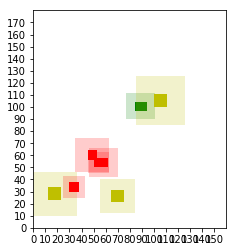

In [3]:
SELECTED_HOUSE_COUNT = HOUSE_COUNT[2]

"""
build a hardcoded sollution
"""
def main():
    ht = initHouseTypes(20)

    # example house object values
    hType = [ht[0], ht[2], ht[0], ht[1], ht[2], ht[0], ht[2], ht[0], ht[1], ht[2]]
    coordinate = [(50, 50), (64, 21), (54, 50), (84, 97), (12, 23), (45, 56), (100, 100), (30, 30), (200, 54)]
    ringsToAdd = [3, 3, 6, 4, 7, 8, 9, 3, 0, 0]

    # make a map
    map1 = Map()

    # fill the map
    for i in range(9):
        map1.addHouse(hType[i], coordinate[i], ringsToAdd[i])


    # draw the map
    map1.plot()

if __name__=="__main__":
    main()


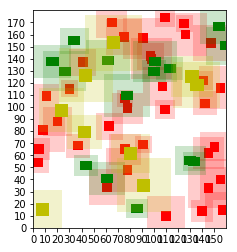

In [4]:
"""
build a random sollution
"""
def main():
    housetypes = initHouseTypes(20)

    # generate hosue parameteres
    housetypelist = []
    for housetype in housetypes:
        n = round(housetype.frequency * SELECTED_HOUSE_COUNT)
        housetypelist += [housetype] * n

    # houstypelist = shuffle(housetypelist)

    # make a map
    map1 = Map()

    # add houses to map
    for i in range(SELECTED_HOUSE_COUNT):

        # create other parameters
        coordinate = (randint(0, AREA[0]-1), randint(0, AREA[1]-1))
        ringsToAdd = randint(1, 12)

        # add house
        map1.addHouse(housetypelist[i], coordinate, ringsToAdd)

    # draw the map
    map1.plot()

if __name__=="__main__":
    main()

## The Next Steps

1.    Are co-ordinates within the boundaries?

2.    Are the houses overlapping? IsTouching Function

3.    Implement random

4.    Combine random algorithm with another, such as greedy


## In Summary

- Now you know why these guys are together 
<img src="http://api.ning.com/files/ypNasbNKTXcuX8sAKF1hgl9WMLVs9l5-2yNWO1Zxn9HCXx*fzBEHgVlY0d-d5*HytvlY-z7M10fTXMO0aTAGvRm66N7iOef*/RhinoGrasshopper.jpg"><img>


- &    this one...
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Snake_icon.svg/830px-Snake_icon.svg.png"><img>


In [5]:
## In terminal in the folder (may have to delete reveal.js)
# jupyter-nbconvert --to slides Beunhaaas.ipynb --reveal-prefix=reveal.js
## Or:
# jupyter nbconvert Beunhaaas.ipynb --to slides --post serve 